In [2]:
!python3 --version

Python 3.9.10


In [3]:
!pip install kaggle

In [ ]:
!pwd

In [4]:
!kaggle competitions download -c nfl-player-contact-detection -p ../data/raw/

nfl-player-contact-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip data/raw/nfl-player-contact-detection.zip -d ../data/raw/

Archive:  data/raw/nfl-player-contact-detection.zip
replace data/raw/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [4]:
import pandas as pd
import numpy as np
train_labels_df = pd.read_csv("../data/raw/train_labels.csv")
train_video_metadata_df = pd.read_csv("../data/raw/train_video_metadata.csv")
train_player_tracking = pd.read_csv("../data/raw/train_player_tracking.csv")

In [5]:
def create_features(df, tr_tracking, merge_col="step", use_cols=["x_position", "y_position"]):
    output_cols = []
    df_combo = (
        df.astype({"nfl_player_id_1": "str"})
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id",] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_1"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .rename(columns={c: c+"_1" for c in use_cols})
        .drop("nfl_player_id", axis=1)
        .merge(
            tr_tracking.astype({"nfl_player_id": "str"})[
                ["game_play", merge_col, "nfl_player_id"] + use_cols
            ],
            left_on=["game_play", merge_col, "nfl_player_id_2"],
            right_on=["game_play", merge_col, "nfl_player_id"],
            how="left",
        )
        .drop("nfl_player_id", axis=1)
        .rename(columns={c: c+"_2" for c in use_cols})
        .sort_values(["game_play", merge_col, "nfl_player_id_1", "nfl_player_id_2"])
        .reset_index(drop=True)
    )
    output_cols += [c+"_1" for c in use_cols]
    output_cols += [c+"_2" for c in use_cols]
    
    if ("x_position" in use_cols) & ("y_position" in use_cols):
        index = df_combo['x_position_2'].notnull()
        
        distance_arr = np.full(len(index), np.nan)
        tmp_distance_arr = np.sqrt(
            np.square(df_combo.loc[index, "x_position_1"] - df_combo.loc[index, "x_position_2"])
            + np.square(df_combo.loc[index, "y_position_1"]- df_combo.loc[index, "y_position_2"])
        )
        
        distance_arr[index] = tmp_distance_arr
        df_combo['distance'] = distance_arr
        output_cols += ["distance"]
        
    df_combo['G_flug'] = (df_combo['nfl_player_id_2']=="G")
    output_cols += ["G_flug"]
    return df_combo, output_cols


use_cols = [
    'x_position', 'y_position', 'speed', 'distance',
    'direction', 'orientation', 'acceleration', 'sa'
]

train, feature_cols = create_features(train_labels_df, train_player_tracking, use_cols=use_cols)

In [6]:
train

contact_id     game_play                  datetime  \
0         58168_003392_0_37084_37211  58168_003392  2020-09-11T03:01:48.100Z   
1         58168_003392_0_37084_38556  58168_003392  2020-09-11T03:01:48.100Z   
2         58168_003392_0_37084_38567  58168_003392  2020-09-11T03:01:48.100Z   
3         58168_003392_0_37084_38590  58168_003392  2020-09-11T03:01:48.100Z   
4         58168_003392_0_37084_39947  58168_003392  2020-09-11T03:01:48.100Z   
...                              ...           ...                       ...   
4721613  58582_003121_91_52500_52619  58582_003121  2021-10-12T02:42:29.100Z   
4721614      58582_003121_91_52500_G  58582_003121  2021-10-12T02:42:29.100Z   
4721615  58582_003121_91_52609_52619  58582_003121  2021-10-12T02:42:29.100Z   
4721616      58582_003121_91_52609_G  58582_003121  2021-10-12T02:42:29.100Z   
4721617      58582_003121_91_52619_G  58582_003121  2021-10-12T02:42:29.100Z   

         step nfl_player_id_1 nfl_player_id_2  contact  x_position_1  \
0           0           37084           37211        0         41.90   
1           0           37084           38556        0         41.90   
2           0           37084           38567        0         41.90   
3           0           37084           38590        0         41.90   
4           0           37084           39947        0         41.90   
...       ...             ...             ...      ...           ...   
4721613    91           52500           52619        0         58.74   
4721614    91           52500               G        0         58.74   
4721615    91           52609           52619        0         60.32   
4721616    91           52609               G        0         60.32   
4721617    91           52619               G        0         58.90   

         y_position_1  speed_1  ...  x_position_2  y_position_2  speed_2  \
0               20.08     0.54  ...         39.59         17.07     0.53   
1               20.08     0.54  ...         41.93         30.61     0.67   
2               20.08     0.54  ...         40.37         19.88     0.66   
3               20.08     0.54  ...         40.33         25.28     0.52   
4               20.08     0.54  ...         40.11         26.73     0.99   
...               ...      ...  ...           ...           ...      ...   
4721613         40.11     1.34  ...         58.90         22.09     1.32   
4721614         40.11     1.34  ...           NaN           NaN      NaN   
4721615         25.93     1.38  ...         58.90         22.09     1.32   
4721616         25.93     1.38  ...           NaN           NaN      NaN   
4721617         22.09     1.32  ...           NaN           NaN      NaN   

         distance_2  direction_2  orientation_2  acceleration_2  sa_2  \
0              0.05       134.84          84.73            1.43  1.42   
1              0.05       232.50         227.00            1.82  1.61   
2              0.07       136.70          88.92            0.90  0.89   
3              0.06       141.08         100.37            0.59  0.58   
4              0.09       163.38          90.69            1.68  1.64   
...             ...          ...            ...             ...   ...   
4721613        0.14        74.21          47.63            0.96 -0.44   
4721614         NaN          NaN            NaN             NaN   NaN   
4721615        0.14        74.21          47.63            0.96 -0.44   
4721616         NaN          NaN            NaN             NaN   NaN   
4721617         NaN          NaN            NaN             NaN   NaN   

          distance  G_flug  
0         3.794232   False  
1        10.530043   False  
2         1.543017   False  
3         5.431841   False  
4         6.886697   False  
...            ...     ...  
4721613  18.020710   False  
4721614        NaN    True  
4721615   4.094142   False  
4721616        NaN    True  
4721617        NaN    True  

[4721618 rows x 25 columns]

In [4]:
train_video_metadata_df.columns

Index(['game_play', 'game_key', 'play_id', 'view', 'start_time', 'end_time',
       'snap_time'],
      dtype='object')

In [5]:
train_video_metadata_df.head()

game_play  game_key  play_id      view                start_time  \
0  58168_003392     58168     3392   Endzone  2020-09-11T03:01:43.134Z   
1  58168_003392     58168     3392  Sideline  2020-09-11T03:01:43.134Z   
2  58172_003247     58172     3247   Endzone  2020-09-13T19:30:42.414Z   
3  58172_003247     58172     3247  Sideline  2020-09-13T19:30:42.414Z   
4  58173_003606     58173     3606   Endzone  2020-09-13T19:45:07.527Z   

                   end_time                 snap_time  
0  2020-09-11T03:01:54.971Z  2020-09-11T03:01:48.134Z  
1  2020-09-11T03:01:54.971Z  2020-09-11T03:01:48.134Z  
2  2020-09-13T19:31:00.524Z  2020-09-13T19:30:47.414Z  
3  2020-09-13T19:31:00.524Z  2020-09-13T19:30:47.414Z  
4  2020-09-13T19:45:26.438Z  2020-09-13T19:45:12.527Z

In [6]:
train_video_metadata_df.shape

(480, 7)

In [7]:
train_labels_df.head()

contact_id     game_play                  datetime  step  \
0  58168_003392_0_38590_43854  58168_003392  2020-09-11T03:01:48.100Z     0   
1  58168_003392_0_38590_41257  58168_003392  2020-09-11T03:01:48.100Z     0   
2  58168_003392_0_38590_41944  58168_003392  2020-09-11T03:01:48.100Z     0   
3  58168_003392_0_38590_42386  58168_003392  2020-09-11T03:01:48.100Z     0   
4  58168_003392_0_38590_47944  58168_003392  2020-09-11T03:01:48.100Z     0   

   nfl_player_id_1 nfl_player_id_2  contact  
0            38590           43854        0  
1            38590           41257        0  
2            38590           41944        0  
3            38590           42386        0  
4            38590           47944        0

In [8]:
train_labels_df.shape

(4721618, 7)

In [9]:
merged_df.shape

(9443236, 13)

In [10]:
train_video_metadata_df.query('game_play == "58168_003392"')

game_play  game_key  play_id      view                start_time  \
0  58168_003392     58168     3392   Endzone  2020-09-11T03:01:43.134Z   
1  58168_003392     58168     3392  Sideline  2020-09-11T03:01:43.134Z   

                   end_time                 snap_time  
0  2020-09-11T03:01:54.971Z  2020-09-11T03:01:48.134Z  
1  2020-09-11T03:01:54.971Z  2020-09-11T03:01:48.134Z

In [11]:
train_labels_df.query('game_play == "58168_003392"')

contact_id     game_play                  datetime  \
0      58168_003392_0_38590_43854  58168_003392  2020-09-11T03:01:48.100Z   
1      58168_003392_0_38590_41257  58168_003392  2020-09-11T03:01:48.100Z   
2      58168_003392_0_38590_41944  58168_003392  2020-09-11T03:01:48.100Z   
3      58168_003392_0_38590_42386  58168_003392  2020-09-11T03:01:48.100Z   
4      58168_003392_0_38590_47944  58168_003392  2020-09-11T03:01:48.100Z   
...                           ...           ...                       ...   
17705     58168_003392_69_45695_G  58168_003392  2020-09-11T03:01:55.000Z   
17706     58168_003392_69_42565_G  58168_003392  2020-09-11T03:01:55.000Z   
17707     58168_003392_69_46445_G  58168_003392  2020-09-11T03:01:55.000Z   
17708     58168_003392_69_40011_G  58168_003392  2020-09-11T03:01:55.000Z   
17709     58168_003392_69_46522_G  58168_003392  2020-09-11T03:01:55.000Z   

       step  nfl_player_id_1 nfl_player_id_2  contact  
0         0            38590           43854        0  
1         0            38590           41257        0  
2         0            38590           41944        0  
3         0            38590           42386        0  
4         0            38590           47944        0  
...     ...              ...             ...      ...  
17705    69            45695               G        0  
17706    69            42565               G        0  
17707    69            46445               G        0  
17708    69            40011               G        0  
17709    69            46522               G        0  

[17710 rows x 7 columns]

In [12]:
merged_df.columns

Index(['contact_id', 'game_play', 'datetime', 'step', 'nfl_player_id_1',
       'nfl_player_id_2', 'contact', 'game_key', 'play_id', 'view',
       'start_time', 'end_time', 'snap_time'],
      dtype='object')

In [ ]:
categorical_cols = test_filtered.select_dtypes(include=['object']).columns
numerical_cols = test_filtered.select_dtypes(include=np.number).columns.tolist()
print("Categorical Features:")
print(categorical_cols)
print("Numerical Features:")
print(numerical_cols)

Sideline
Number of frames: 711.0
Frame width: 1280.0
Frame height: 720.0


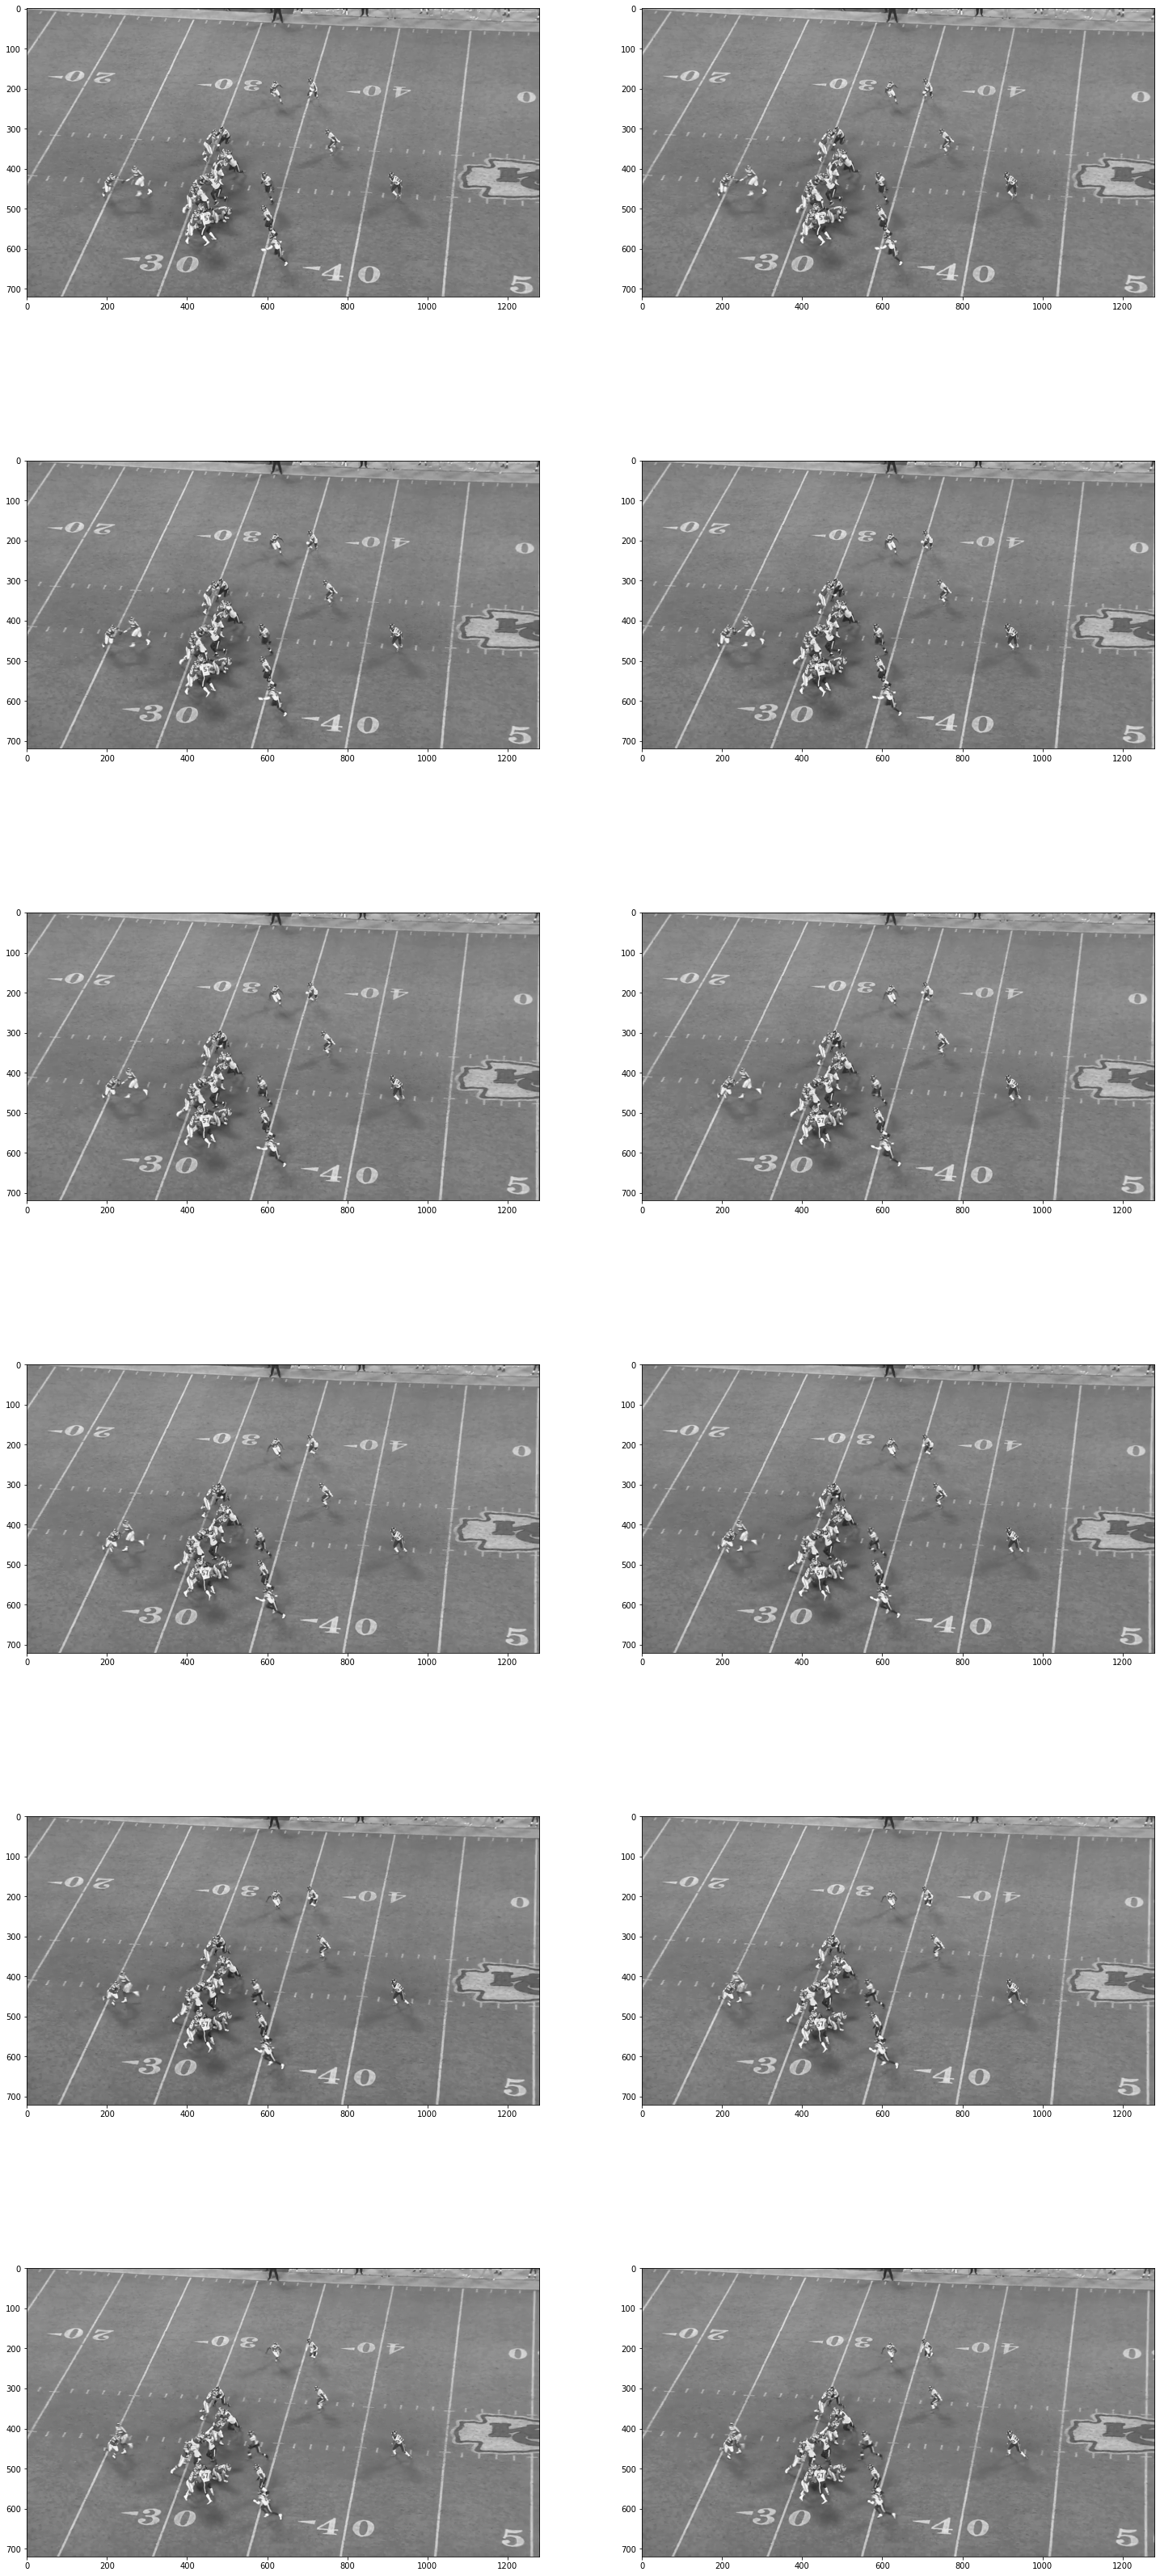

In [20]:
import cv2
import matplotlib.pyplot as plt

game_play = merged_df['game_play'][4]
view = merged_df['view'][15001]

def get_video_view(file_path):

    # Opening the video file usiunique.VideoCapture
    video_capture = cv2.VideoCapture(file_path)

    print(view)

    # Checking if the video was opened successfully
    # by calling the .isOpened() method on the VideoCapture object
    if not video_capture.isOpened():
        print('Error opening video file')

    # Basic information about the video
    # such as the number of frames and the frame width and height
    num_frames = video_capture.get(cv2.CAP_PROP_FRAME_COUNT)
    frame_width = video_capture.get(cv2.CAP_PROP_FRAME_WIDTH)
    frame_height = video_capture.get(cv2.CAP_PROP_FRAME_HEIGHT)
    print(f'Number of frames: {num_frames}')
    print(f'Frame width: {frame_width}')
    print(f'Frame height: {frame_height}')

    frames = []  # Storing the frames in a list so that we can display them later
    while True:
        # Using the .read() method of the VideoCapture object
        # to read the next frame of the video
        ret, frame = video_capture.read()

        # If the .read() method returns False, it means we have reached the end of the video
        if not ret:
            break

        # Processing the frame:
        # Converting the frame to grayscale using cv2.cvtColor
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Let's store the processed frame in the list
        frames.append(frame)
    # Release the VideoCapture object to free up memory
    video_capture.release()
    return frames
file_path = f"../data/raw/train/{game_play}_{view}.mp4"
frames = get_video_view(file_path)
# After processing all the frames, let's display them using matplotlib
# using subplots to display multiple frames in a single figure
fig, axs = plt.subplots(nrows=6, ncols=2, figsize=(25, 60))
axs = axs.flatten()
for ax, frame in zip(axs, frames[360:]):
    ax.imshow(frame, cmap='gray')
plt.show()



### Processing the video frames further

In [21]:
# Crop the frames to only keep the region of interest
cropped_frames = []
for frame in frames:
    x1, y1, x2, y2 = 190, 250, 650, 620
    cropped_frame = frame[y1:y2, x1:x2]
    cropped_frames.append(cropped_frame)

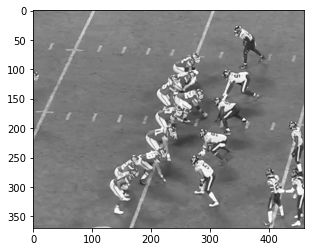

In [22]:
plt.imshow(cropped_frames[2], cmap='gray')
plt.show()

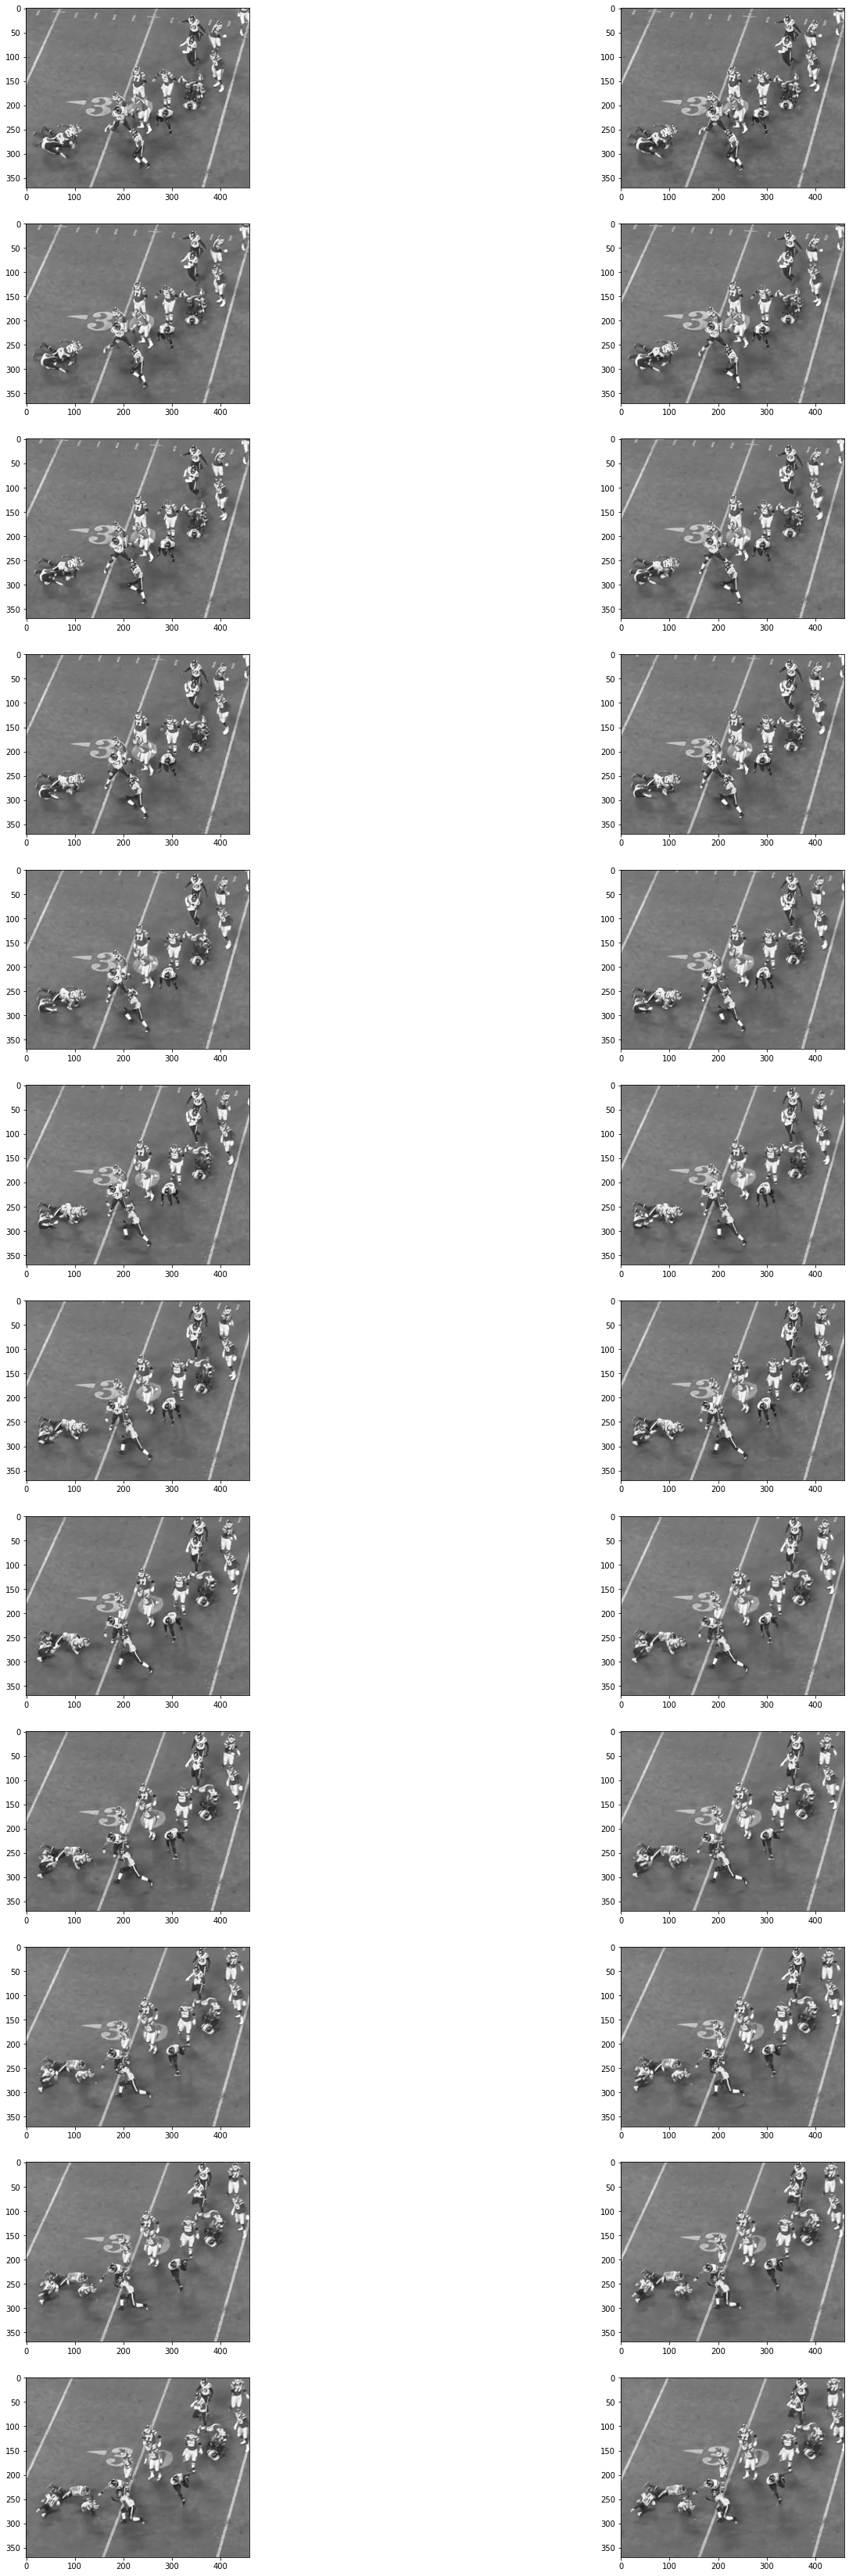

In [23]:
fig, axs = plt.subplots(nrows=12, ncols=2, figsize=(25, 60))
axs = axs.flatten()
for ax, frame in zip(axs, cropped_frames[500:]):
    ax.imshow(frame, cmap='gray')
plt.show()

In [24]:
import sys
sys.path.append("/root/playerContactDetection")

In [25]:
print(sys.path)

['/root/playerContactDetection/notebooks', '/usr/local/lib/python39.zip', '/usr/local/lib/python3.9', '/usr/local/lib/python3.9/lib-dynload', '', '/usr/local/lib/python3.9/site-packages', '/usr/local/lib/python3.9/site-packages/smdebug-1.0.25b20230114-py3.9.egg', '/usr/local/lib/python3.9/site-packages/pyinstrument-3.4.2-py3.9.egg', '/usr/local/lib/python3.9/site-packages/pyinstrument_cext-0.2.4-py3.9-linux-x86_64.egg', '/usr/local/lib/python3.9/site-packages/IPython/extensions', '/root/.ipython', '/root/playerContactDetection']


In [26]:
from src.crop_frames import crop_video_frames

In [ ]:
videos_path = '../data/raw/train/'
video_file_paths = []
processed_file_path = '../data/processed/'
def construct_endzone_videos() -> list:
    for i in merged_df.game_play:
        video_name = f"{i}_Endzone.mp4"
        video_file_paths.append(videos_path + video_name)
    return video_file_paths

def construct_sideline_videos() -> list:
    for i in merged_df.game_play:
        video_name = f"{i}_Sidline.mp4"
        video_file_paths.append(videos_path + video_name)
    return video_file_paths

def crop_sideline_frames(video_path):
    roi = (190, 250, 650, 620) # Example ROI for Sideline view
    return crop_video_frames(video_path, roi)

def crop_endzone_frames(video_path):
    roi = (0, 200, 650, 500) # Example ROI for Endzone view
    return crop_video_frames(video_path, roi)

# construct the two views' paths' lists and concat them in one list
video_file_paths = construct_sideline_videos() + construct_endzone_videos()
print(video_file_paths)
for video_file_path in video_file_paths:
    view = get_video_view(video_file_path)
    if view == 'Sideline':
        cropped_frames = crop_sideline_frames(video_file_path)
    elif view == 'Endzone':
        cropped_frames = crop_endzone_frames(video_file_path)
    for i, frame in enumerate(cropped_frames):
        cv2.imwrite(processed_file_path+video_file_path.split("/")[-1]+f"_frame_{i}.jpg", frame)